# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

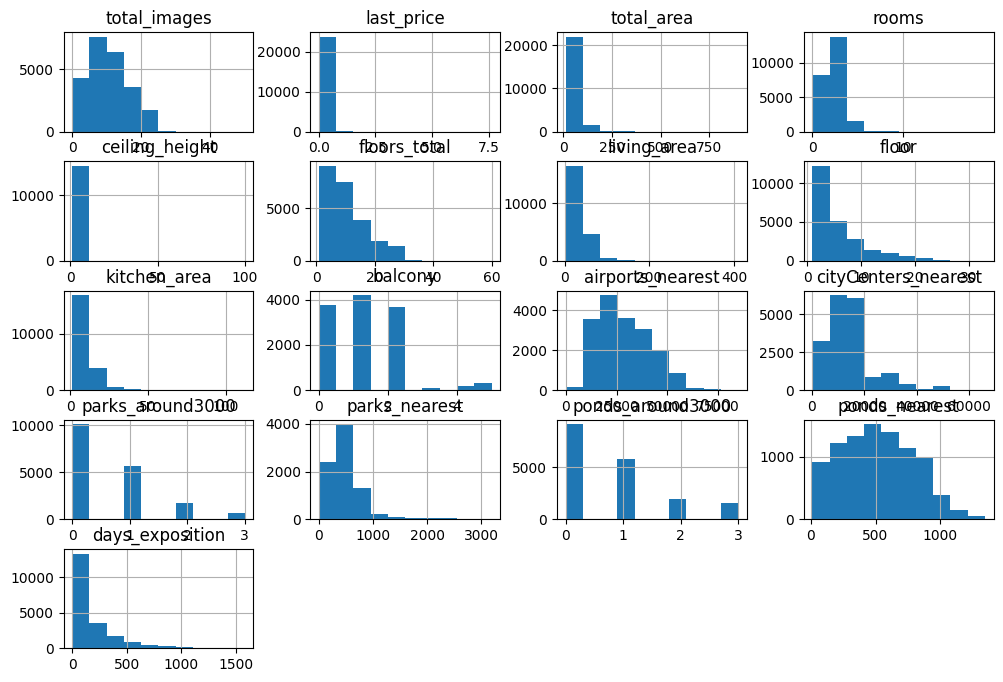

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

filepath = r"C:\Users\erofe\Downloads\real_estate_data.csv"
data = pd.read_csv(filepath, sep='\t')

print(data.info())
# строим общую гистограмму для всех столбцов таблицы
data.hist(figsize=(12, 8))
plt.show()

<Axes: >

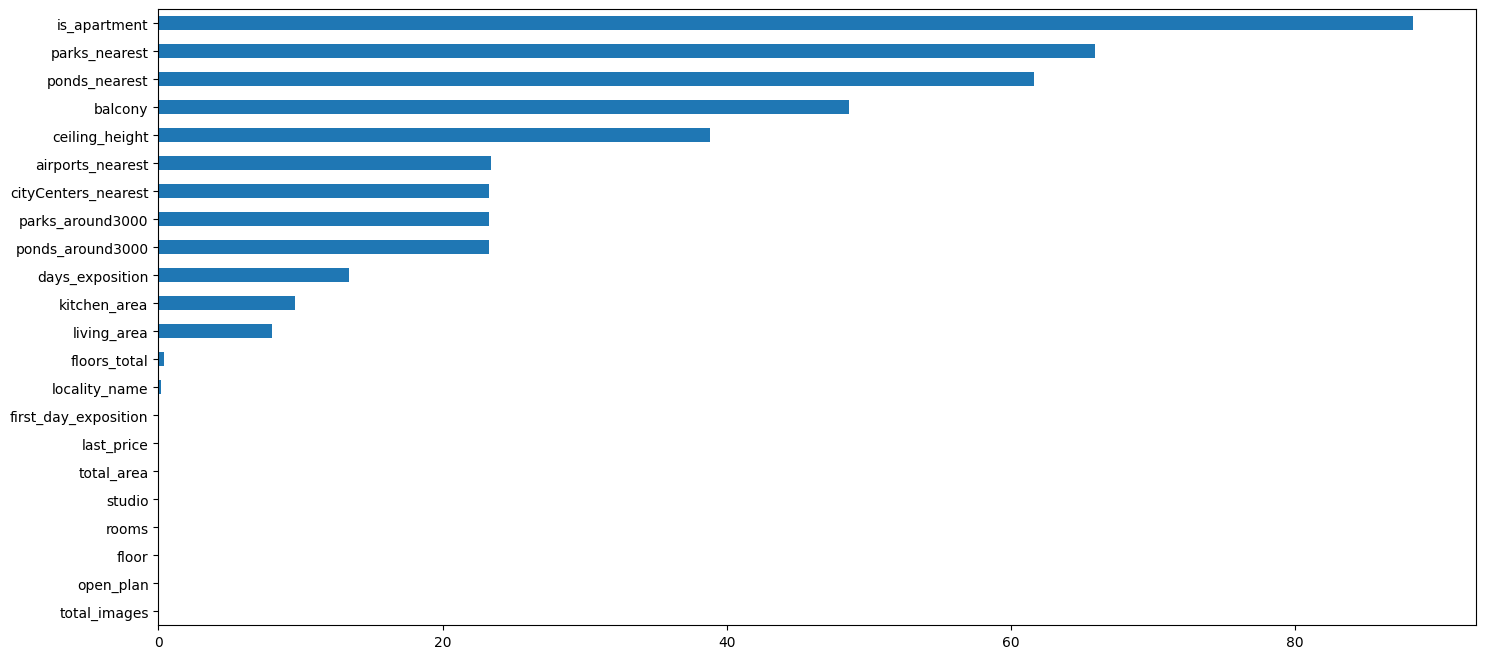

In [2]:
#строим таблицу с процентом пропусков по столбцам
nulls = (data.isnull().sum()/len(data)*100).sort_values().round(1)
nulls.plot(kind = 'barh', figsize=(17, 8))

Вывод: Найдены пропуски, выбросы и дубликаты, которые будут устранены в предобработке данных

## Предобработка данных

In [4]:
#заменим пропуски там, где их настоящие значение 0, так же меняем тип данных на нужный нам
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
#тут пропуски являются скорее меткой, что данная квартира не аппартаменты, так что ставим значение False
data['is_apartment'] = data['is_apartment'].fillna(False)
data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].astype('int')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['days_exposition'] = data['days_exposition'].fillna(0).astype('int')
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(0)
# Заменяем пустые значения жилой площади и площади кухни
living_ratio = data['living_area'].mean() / data['total_area'].mean()
kitchen_ratio = data['kitchen_area'].mean() / data['total_area'].mean()
data['living_area'].fillna(living_ratio * data['total_area'], inplace=True)
data['kitchen_area'].fillna(kitchen_ratio * data['total_area'], inplace=True)

In [6]:
#удаляем выбросы в высоте потолков
ceiling_medians = data.pivot_table(index='floors_total', values='ceiling_height', aggfunc=['median', 'count'])
ceiling_medians.columns = ['median', 'count']
ceiling_medians.head()
for floor in ceiling_medians.index:
    data.loc[(data['ceiling_height'].isna()) & 
             (data['floors_total'] == floor), 
             'ceiling_height'] = ceiling_medians.loc[floor, 'median']
for floor in ceiling_medians.index:
    data.loc[(data['floors_total'].isna()) | 
             ((data['floors_total'] == floor) & (ceiling_medians.loc[floor, 'count'] == 0)), 
             'ceiling_height'] = data['ceiling_height'].describe().iloc[5]

In [7]:
#заменяем неявные дубликаты
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
print(data['locality_name'].unique())

['Санкт-Петербург' 'поселок Шушары' 'городской поселок Янино-1'
 'поселок Парголово' 'поселок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'деревня Федоровское'
 'Выборг' 'Кронштадт' 'Кировск' 'деревня Новое Девяткино'
 'поселок Металлострой' 'поселок городского типа Лебяжье'
 'поселок городского типа Сиверский' 'поселок Молодцово'
 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'поселок Аннино' 'поселок городского типа Ефимовский'
 'поселок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'поселок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'поселок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'деревня Оржицы' 'деревня Кальтино'

In [8]:
#строим функцию для удаления выбросов
def remove_outliers(data, column_name, threshold=1.5):
    
    # Вычисляем квартили для столбца
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    
    # Вычисляем IQR
    IQR = Q3 - Q1
    
    # Вычисляем границы для определения выбросов
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    # Удаляем выбросы
    data_cleaned = data[(data[column_name] >= lower_bound) & (data[column_name] <= upper_bound)]
    
    return data_cleaned


In [9]:
#удаляем выбросы, где возможно, в остальных случаях, либо не числовые значения, либо теряется слишком большой процент данных
cleaned_data = remove_outliers(data, 'total_area')
print (f"Процент потерянных значений: {(1 - len(cleaned_data['total_area']) / len(data['total_area'])) * 100:.2f}%")
cleaned_data0 = remove_outliers(cleaned_data, 'living_area')
print (f"Процент потерянных значений: {(1 - len(cleaned_data0['living_area']) / len(cleaned_data['living_area'])) * 100:.2f}%")
cleaned_data1 = remove_outliers(cleaned_data0, 'kitchen_area')
print (f"Процент потерянных значений: {(1 - len(cleaned_data1['kitchen_area']) / len(cleaned_data0['kitchen_area'])) * 100:.2f}%")
cleaned_data2 = remove_outliers(cleaned_data1, 'floors_total')
print (f"Процент потерянных значений: {(1 - len(cleaned_data2['floors_total']) / len(cleaned_data1['floors_total'])) * 100:.2f}%")
cleaned_data3 = remove_outliers(cleaned_data2, 'cityCenters_nearest')
print (f"Процент потерянных значений: {(1 - len(cleaned_data3['cityCenters_nearest']) / len(cleaned_data2['cityCenters_nearest'])) * 100:.2f}%")
cleaned_data4 = remove_outliers(cleaned_data3, 'days_exposition')
print (f"Процент потерянных значений: {(1 - len(cleaned_data4['days_exposition']) / len(cleaned_data3['days_exposition'])) * 100:.2f}%")
cleaned_data5 = remove_outliers(cleaned_data4, 'balcony')
print (f"Процент потерянных значений: {(1 - len(cleaned_data5['balcony']) / len(cleaned_data4['balcony'])) * 100:.2f}%")
cleaned_data6 = remove_outliers(cleaned_data5, 'floor')
print (f"Процент потерянных значений: {(1 - len(cleaned_data6['floor']) / len(cleaned_data5['floor'])) * 100:.2f}%")
cleaned_data7 = remove_outliers(cleaned_data6, 'rooms')
print (f"Процент потерянных значений: {(1 - len(cleaned_data7['rooms']) / len(cleaned_data6['rooms'])) * 100:.2f}%")
cleaned_data8 = remove_outliers(cleaned_data7, 'total_images')
print (f"Процент потерянных значений: {(1 - len(cleaned_data8['total_images']) / len(cleaned_data7['total_images'])) * 100:.2f}%")
cleaned_data9 = remove_outliers(cleaned_data8, 'parks_around3000')
print (f"Процент потерянных значений: {(1 - len(cleaned_data9['parks_around3000']) / len(cleaned_data8['parks_around3000'])) * 100:.2f}%")
cleaned_data00 = remove_outliers(cleaned_data9, 'ponds_around3000')
print (f"Процент потерянных значений: {(1 - len(cleaned_data00['ponds_around3000']) / len(cleaned_data9['ponds_around3000'])) * 100:.2f}%")
##во всех случаях снизу теряется слишком большой процент данных
#cleaned_data = remove_outliers(data, 'ponds_nearest')
#print (f"Процент потерянных значений: {(1 - len(cleaned_data['ponds_nearest']) / len(data['ponds_nearest'])) * 100:.2f}%")
#cleaned_data = remove_outliers(data, 'airports_nearest')
#print (f"Процент потерянных значений: {(1 - len(cleaned_data['airports_nearest']) / len(data['airports_nearest'])) * 100:.2f}%")
#cleaned_data = remove_outliers(data, 'parks_nearest')
#print (f"Процент потерянных значений: {(1 - len(cleaned_data['parks_nearest']) / len(data['parks_nearest'])) * 100:.2f}%")
##делаем данное движение для удобства будущей работы
data = cleaned_data00

Процент потерянных значений: 5.23%
Процент потерянных значений: 0.58%
Процент потерянных значений: 4.57%
Процент потерянных значений: 0.46%
Процент потерянных значений: 1.38%
Процент потерянных значений: 8.45%
Процент потерянных значений: 2.16%
Процент потерянных значений: 3.76%
Процент потерянных значений: 0.00%
Процент потерянных значений: 0.08%
Процент потерянных значений: 1.99%
Процент потерянных значений: 4.11%


In [10]:
low_percentele = 0.01
hihg_percentele = 0.99

last_price_low = data['last_price'].quantile(low_percentele)
last_price_high = data['last_price'].quantile(hihg_percentele)

print(f'Нижняя граница last_price {last_price_low}')
print(f'Верхняя граница last_price {last_price_high}')

print(
    'Процент отброшенных значений = ',
    round(
        100 - len(data.query('@last_price_low <= last_price <= @last_price_high'))
        / len(data['last_price']) * 100,
        2
    ),
    '%'
)

Нижняя граница last_price 947152.5
Верхняя граница last_price 13400000.0
Процент отброшенных значений =  2.0 %


Предобработка закончена. Были уничтожены выбросы во всех столбцах с числовыми данными, кроме тех, где это удаляло более 10 процентов данных(а именно кроме столбцов с ближайшими парками, аэропортами и водоёмами). Для удаления выбросов была создана специальная функция "remove_outliers". Так же были уничтожены неявные дубликаты в столбце с названиями населенных пунктов. Так же были заменены пропущенные значения, в основном на нули, но в столбцах с жилой и кухонной площадью, были заменены по специальным формулам, а в столбце апартаментов пропущенные значения были заменены на False(то есть, то что данная строка не про аппартаменты). Так же были изменения в типе данных, в основном из плавающих в целочисленные, но в столбце с датой размещения обьявления, тип данных был изменен на дату.

## Добавление в таблицу новых столбцов

In [11]:
#цена квадратного метра
data['price_per_metre'] = data['last_price']/data['total_area']
#столбец дня недели
data['weekday'] = data['first_day_exposition'].dt.weekday
#столбец месяца
data['month'] = data['first_day_exposition'].dt.month
#столбец года
data['year'] = data['first_day_exposition'].dt.year
#функция категоризации по этажам
def floor_type(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'
    
#категоризируем этажи
data['floor_type'] = data.apply(floor_type, axis = 1)
#делаем расстояние до центра в километрах    
data['cityCenters_nearest_km'] = data['cityCenters_nearest']/1000
#меняем тип данных нга числовой
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].astype('int')

## Исследовательский анализ данных

Строем гистограммы по интересующем нам столбцам и изучаем их

<Axes: ylabel='Frequency'>

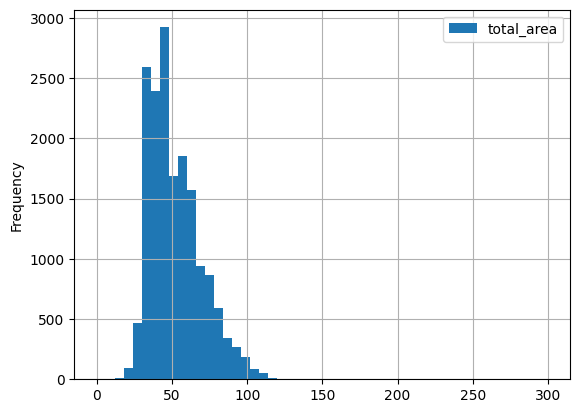

In [12]:
data.plot(y = 'total_area', kind = 'hist', bins = 50, grid=True, range = (0,300))

самая популярная площадь квартиры для продажи около 50 квадратных метров, распределение нормальное

<Axes: ylabel='Frequency'>

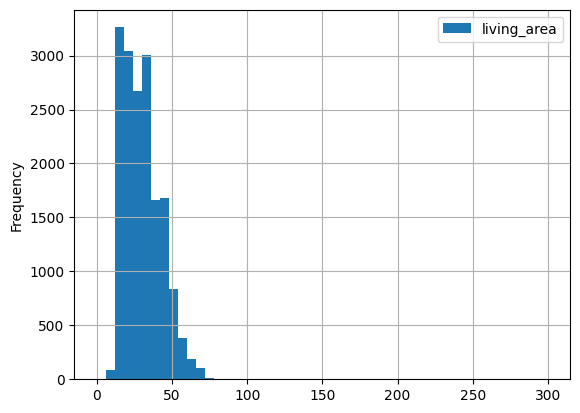

In [13]:
data.plot(y = 'living_area', kind = 'hist', bins = 50, grid=True, range = (0,300))

самая популярная площадь квартиры для продажи около 25 квадратных метров, распределение нормальное

<Axes: ylabel='Frequency'>

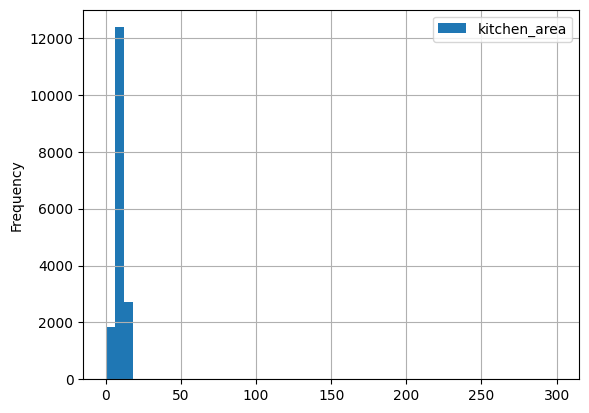

In [14]:
data.plot(y = 'kitchen_area', kind = 'hist', bins = 50, grid=True, range = (0, 300))

самая популярная площадь квартиры для продажи около 15 квадратных метров, распределение нормальное 

<Axes: ylabel='Frequency'>

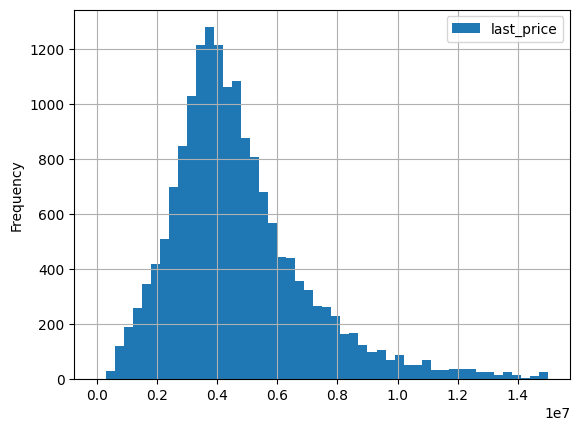

In [15]:
data.plot(y = 'last_price', kind = 'hist', bins = 50, grid=True, range = (0,15000000))

самая популярная цена квартиры для продажи около 4 миллионов рублей, распределение нормальное 

<Axes: ylabel='Frequency'>

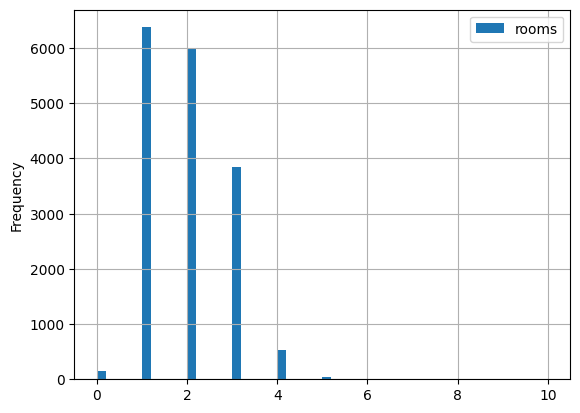

In [16]:
data.plot(y = 'rooms', kind = 'hist', bins = 50, grid=True, range = (0,10))

самое популярное количество комнат в квартире для продажи около 1-2, распределение нормальное

<Axes: ylabel='Frequency'>

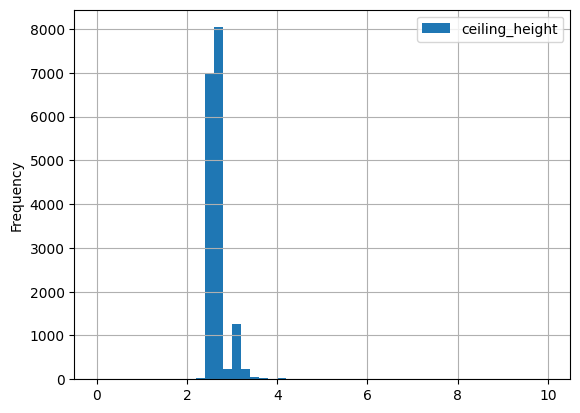

In [17]:
data.plot(y = 'ceiling_height', kind = 'hist', bins = 50, grid=True, range = (0,10))

самая популярная высота потолков в квартире для продажи около 2-3 метров, распределение нормальное

<Axes: ylabel='Frequency'>

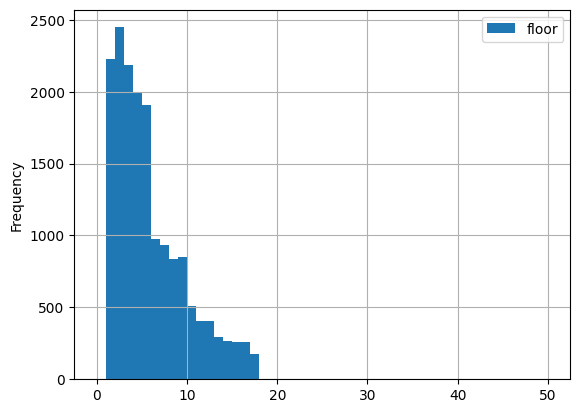

In [18]:
data.plot(y = 'floor', kind = 'hist', bins = 50, grid=True, range = (0,50))

по данным видно, что люди живут, в основном, на 1-6 этажах

<Axes: xlabel='floor_type'>

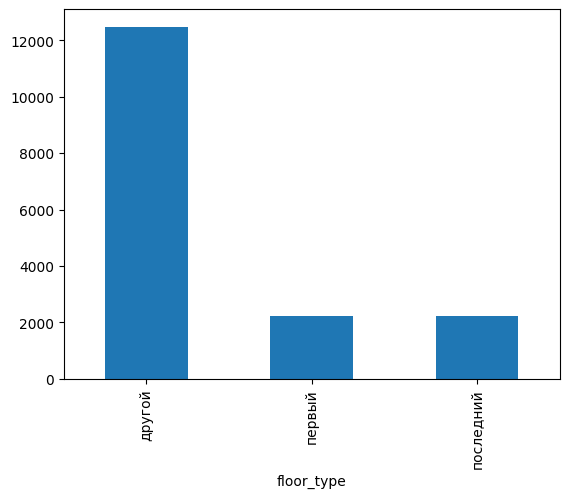

In [19]:
data.floor_type.value_counts().plot.bar()

по данным сложно что-то судить

<Axes: ylabel='Frequency'>

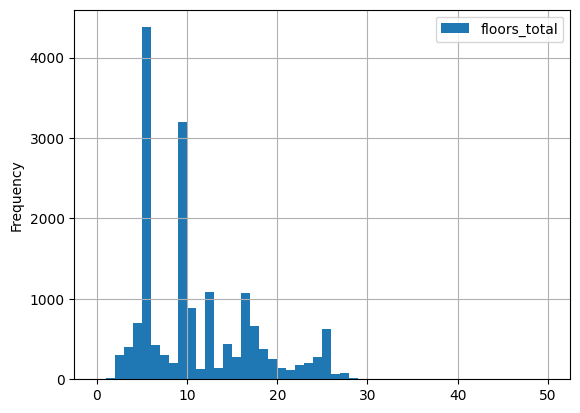

In [20]:
data.plot(y = 'floors_total', kind = 'hist', bins = 50, grid=True, range = (0,50))

самая популярное количество этажей в квартире это 6 или 9, распределение нормальное

<Axes: ylabel='Frequency'>

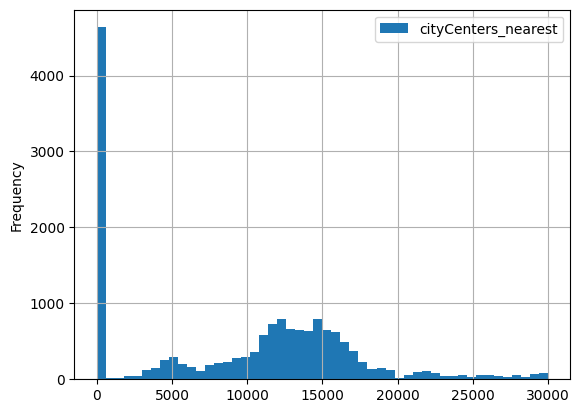

In [21]:
data.plot(y = 'cityCenters_nearest', kind = 'hist', bins = 50, grid=True, range = (0,30000))

огромное значение в нуле, является показателем, что квартиры находятся в центре(что и является самым популярным выбором), распределение нормальное

<Axes: ylabel='Frequency'>

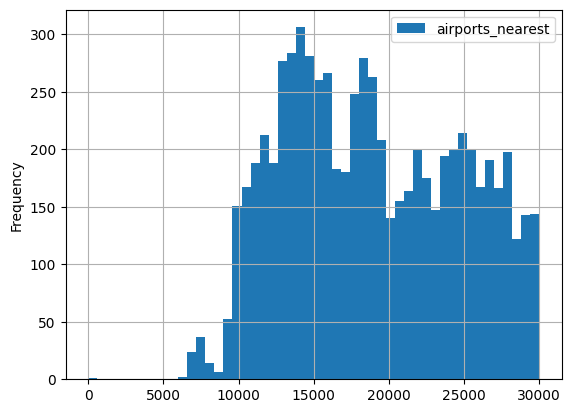

In [22]:
data.plot(y = 'airports_nearest', kind = 'hist', bins = 50, grid=True, range = (0,30000))

по данным сложно что-либо судить, распределение нормальное

<Axes: ylabel='Frequency'>

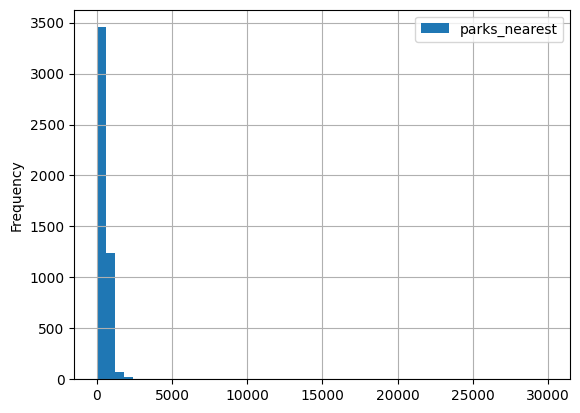

In [23]:
data.plot(y = 'parks_nearest', kind = 'hist', bins = 50, grid=True, range = (0,30000))

по данным сложно что-либо судить, распределение нормальное

<Axes: ylabel='Frequency'>

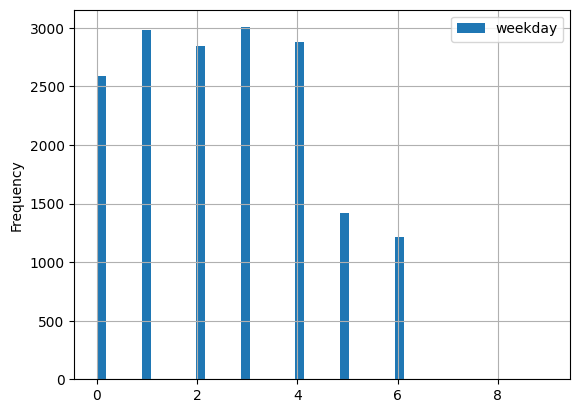

In [24]:
data.plot(y = 'weekday', kind = 'hist', bins = 50, grid=True, range = (0,9))

по данным сложно что-либо судить, распределение нормальное

<Axes: ylabel='Frequency'>

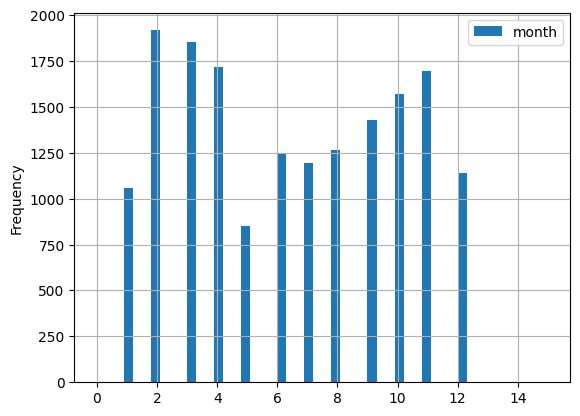

In [25]:
data.plot(y = 'month', kind = 'hist', bins = 50, grid=True, range = (0,15))

по данным сложно что-либо судить, распределение нормальное

Вывод:
Площадь недвижимости: В выборке представлены объекты с площадью от 12 до 900 м2. Среднее значение площади составляет 60 м2, а медиана (значение, разделяющее выборку пополам) равна 52 м2. Упоминание о распределении данных как "Гауссовском" может означать, что площадь имеет некоторое сходство с нормальным распределением, то есть большинство объектов имеют площадь близкую к средней.

Цены на недвижимость: Средняя цена объектов недвижимости составляет 6,5 миллионов рублей, а медианное значение (середина распределения цен) равно 4,6 миллионам рублей. Как и в случае с площадью, упоминание о "Гауссовском" распределении может указывать на то, что цены на недвижимость имеют тенденцию быть более или менее нормально распределенными вокруг среднего значения.

Количество комнат: В выборке присутствуют недвижимость с количеством комнат от 1 до 19. Отмечается, что наибольшее количество объектов - однокомнатные квартиры. Однако неясно, какое именно распределение имеет количество комнат.

Высота потолков: Средняя высота потолков составляет 2,77 метра, медианное значение - 2,65 метра. Это может указывать на некоторую вариабельность в высоте потолков, но также возможно наличие определенного сходства с нормальным распределением.

count    14656.000000
mean       115.660822
std        106.544694
min          1.000000
25%         38.000000
50%         76.000000
75%        167.000000
max        443.000000
Name: days_exposition, dtype: float64

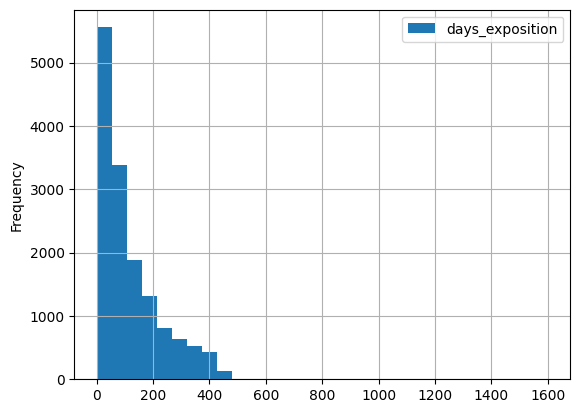

In [26]:
data.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,1600))

data[data['days_exposition']!=0]['days_exposition'].describe()

Вывод: Cудя по гистограмме - мы имеем распределение Пуассона. Среднее значение - 180 дней, а медиана - 95 дней.

Корреляция между 'total_area' и 'last_price': 0.6750412628779561


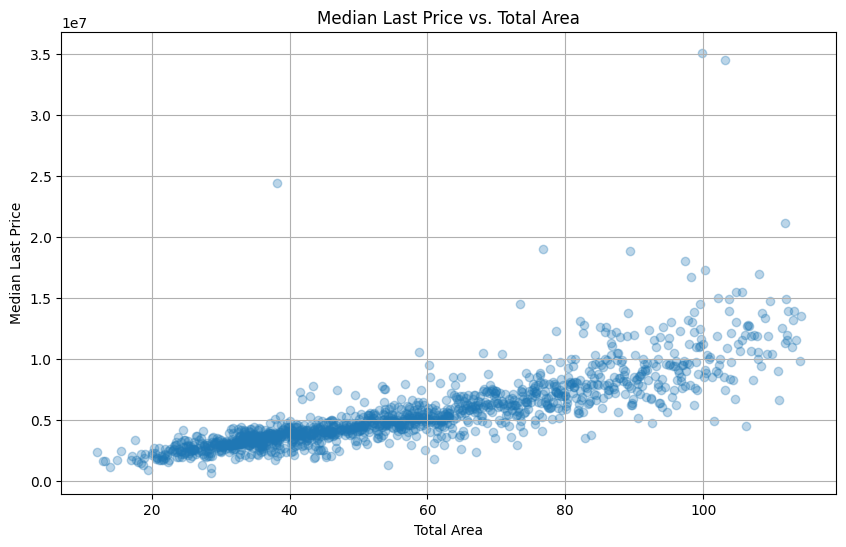

In [27]:
# Выборка необходимых данных
total_area = data['total_area']
last_price = data['last_price']

# Вычисление уникальных значений 'total_area' и создание пустых списков для хранения результатов
unique_total_areas = total_area.unique()
mean_last_prices = []
count_last_prices = []
median_last_prices = []

# Проход по уникальным значениям 'total_area' и вычисление среднего, количества и медианы для каждого значения
for area in unique_total_areas:
    area_data = data[data['total_area'] == area]
    mean_last_prices.append(area_data['last_price'].mean())
    count_last_prices.append(area_data['last_price'].count())
    median_last_prices.append(area_data['last_price'].median())

# Создание DataFrame из результатов
result_data = pd.DataFrame({
    'total_area': unique_total_areas,
    'mean_last_price': mean_last_prices,
    'count_last_price': count_last_prices,
    'median_last_price': median_last_prices
})

# Строим график медианы
plt.figure(figsize=(10, 6))
plt.scatter(result_data['total_area'], result_data['median_last_price'], alpha=0.3)
plt.xlabel('Total Area')
plt.ylabel('Median Last Price')
plt.title('Median Last Price vs. Total Area')
plt.grid(True)

# Сортировка данных по медиане
sorted_data = result_data.sort_values('median_last_price', ascending=False)

# Вычисление корреляции
correlation = total_area.corr(last_price)

print("Корреляция между 'total_area' и 'last_price':", correlation)

Вывод: мы наблюдаем, что существует связь, указанная коэффициентом корреляции Пирсона 0.67. Это означает, что с увеличением площади стоимость тенденцию к повышению
.

Корреляция между 'living_area' и 'last_price': 0.565684910882602


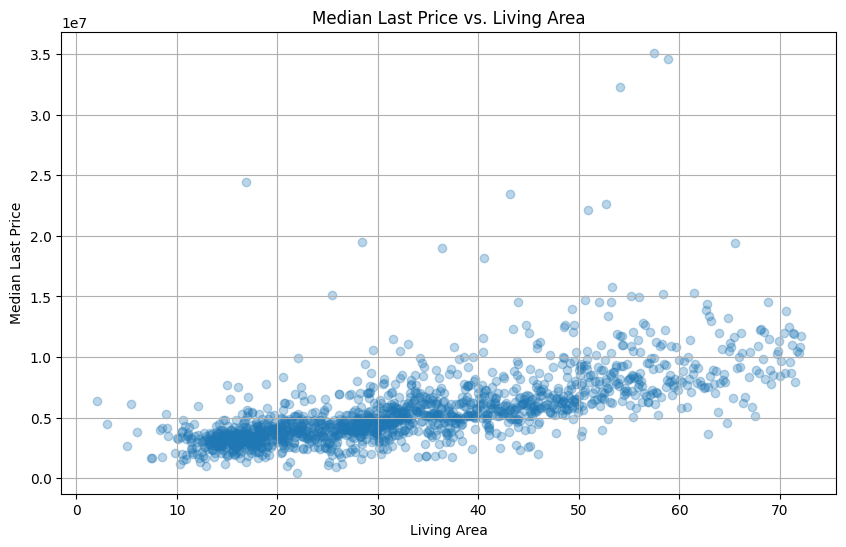

In [28]:
# Выборка необходимых данных
living_area = data['living_area']
last_price = data['last_price']

# Вычисление уникальных значений 'living_area' и создание пустых списков для хранения результатов
unique_living_areas = living_area.unique()
mean_last_prices = []
count_last_prices = []
median_last_prices = []

# Проход по уникальным значениям 'living_area' и вычисление среднего, количества и медианы для каждого значения
for area in unique_living_areas:
    area_data = data[data['living_area'] == area]
    mean_last_prices.append(area_data['last_price'].mean())
    count_last_prices.append(area_data['last_price'].count())
    median_last_prices.append(area_data['last_price'].median())

# Создание DataFrame из результатов
result_data = pd.DataFrame({
    'living_area': unique_living_areas,
    'mean_last_price': mean_last_prices,
    'count_last_price': count_last_prices,
    'median_last_price': median_last_prices
})

# Строим график медианы
plt.figure(figsize=(10, 6))
plt.scatter(result_data['living_area'], result_data['median_last_price'], alpha=0.3)
plt.xlabel('Living Area')
plt.ylabel('Median Last Price')
plt.title('Median Last Price vs. Living Area')
plt.grid(True)

# Сортировка данных по медиане
sorted_data = result_data.sort_values('median_last_price', ascending=False)

# Вычисление корреляции
correlation = living_area.corr(last_price)

print("Корреляция между 'living_area' и 'last_price':", correlation)

Вывод: такая же связь так как коэффициент Пирсона - 0.56

Корреляция между 'kitchen_area' и 'last_price': 0.49469234591592537


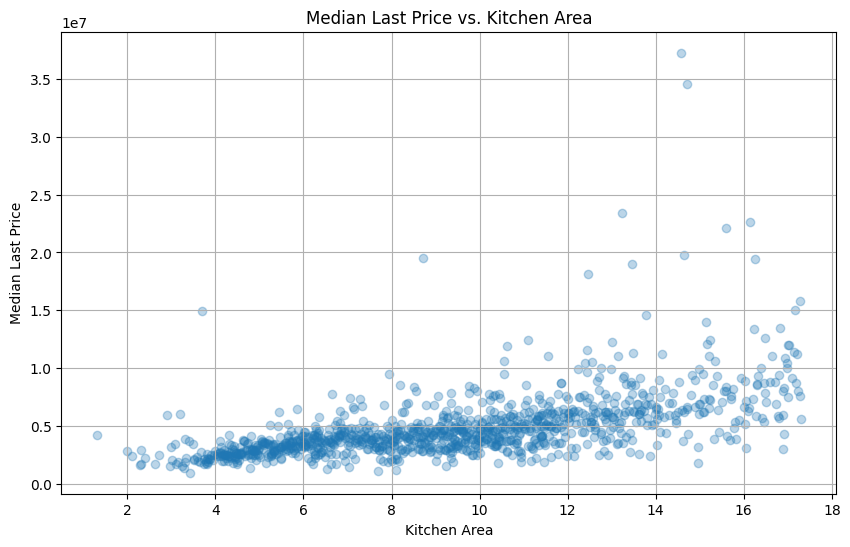

In [29]:
# Выборка необходимых данных
kitchen_area = data['kitchen_area']
last_price = data['last_price']

# Вычисление уникальных значений 'kitchen_area' и создание пустых списков для хранения результатов
unique_kitchen_areas = kitchen_area.unique()
mean_last_prices = []
count_last_prices = []
median_last_prices = []

# Проход по уникальным значениям 'kitchen_area' и вычисление среднего, количества и медианы для каждого значения
for area in unique_kitchen_areas:
    area_data = data[data['kitchen_area'] == area]
    mean_last_prices.append(area_data['last_price'].mean())
    count_last_prices.append(area_data['last_price'].count())
    median_last_prices.append(area_data['last_price'].median())

# Создание DataFrame из результатов
result_data = pd.DataFrame({
    'kitchen_area': unique_kitchen_areas,
    'mean_last_price': mean_last_prices,
    'count_last_price': count_last_prices,
    'median_last_price': median_last_prices
})

# Строим график медианы
plt.figure(figsize=(10, 6))
plt.scatter(result_data['kitchen_area'], result_data['median_last_price'], alpha=0.3)
plt.xlabel('Kitchen Area')
plt.ylabel('Median Last Price')
plt.title('Median Last Price vs. Kitchen Area')
plt.grid(True)

# Сортировка данных по медиане
sorted_data = result_data.sort_values('median_last_price', ascending=False)

# Вычисление корреляции
correlation = kitchen_area.corr(last_price)

print("Корреляция между 'kitchen_area' и 'last_price':", correlation)

Вывод: такая же ситуация только коэффициент чуть пониже почти 0.5

0.40787057301847995

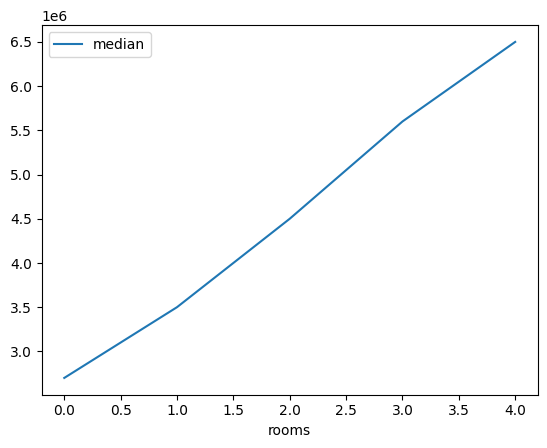

In [30]:
pivot_table_rooms = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_rooms.columns = ['mean', 'count', 'median']
pivot_table_rooms.query('count > 50').plot(y = 'median')

pivot_table_rooms.query('count > 50').sort_values('median', ascending = False)

data['rooms'].corr(data['last_price'])

Вывод: наблюдается прямая зависимость между количеством комнат и стоимостью квадратного метра.

,mean,count,median
floor_type,,,
другой,4.964045e+06,12480,4465000.0
первый,3.986620e+06,2229,3699000.0
последний,4.300720e+06,2225,3800000.0


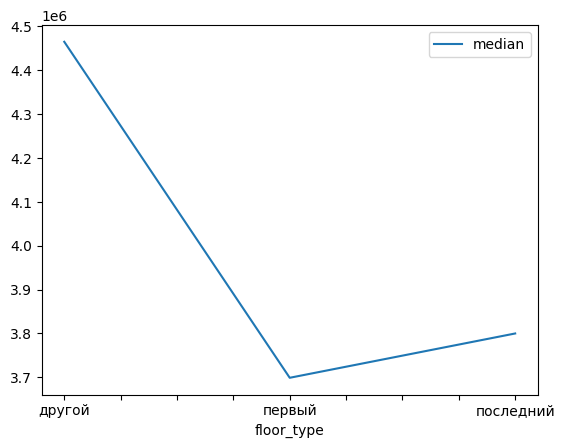

In [31]:
pivot_table_floor_type = data.pivot_table(index = 'floor_type', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_floor_type.columns = ['mean', 'count', 'median']
pivot_table_floor_type.plot(y = 'median')
pivot_table_floor_type

Вывод: Визуально из графика сложно извлечь понятные заключения. Однако, при анализе медианных значений видно, что квартиры на первом этаже обычно дешевле, чем квартиры на последнем этаже.

,mean,count,median
weekday,,,
0,4.771843e+06,2588,4300000.0
2,4.793818e+06,2843,4300000.0
5,4.685921e+06,1422,4290000.0
1,4.763471e+06,2977,4250000.0
3,4.746733e+06,3004,4250000.0
4,4.728608e+06,2882,4200000.0
6,4.677290e+06,1218,4200000.0


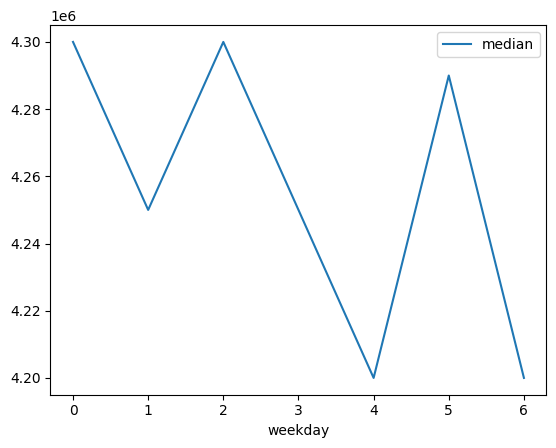

In [32]:
pivot_table_weekday = data.pivot_table(index = 'weekday', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_weekday.columns = ['mean', 'count', 'median']
pivot_table_weekday.plot(y = 'median')

pivot_table_weekday.sort_values('median', ascending = False)

Вывод: Замечаем, что в пятницу и воскресенье самая низкая средняя стоимость недвижимости, в то время как в понедельник и среду самая высокая.

,mean,count,median
month,,,
4,4.822198e+06,1717,4450000.0
3,4.818029e+06,1853,4300000.0
9,4.847678e+06,1431,4300000.0
11,4.775226e+06,1695,4300000.0
2,4.687069e+06,1917,4250000.0
5,4.616403e+06,851,4250000.0
1,4.674446e+06,1057,4246000.0
7,4.745856e+06,1194,4200000.0
8,4.746824e+06,1263,4200000.0


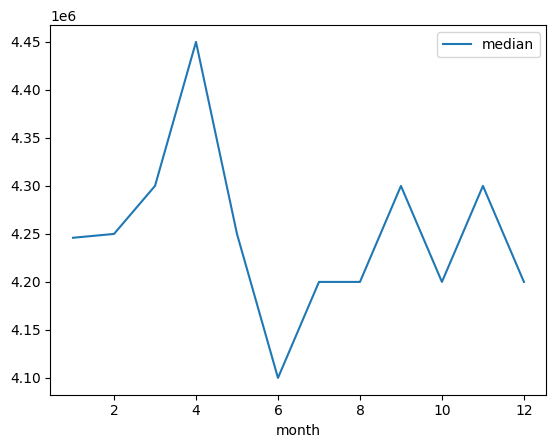

In [33]:
pivot_table_month = data.pivot_table(index = 'month', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_month.columns = ['mean', 'count', 'median']
pivot_table_month.plot(y = 'median')

pivot_table_month.sort_values('median', ascending = False)

Вывод: Мы можем наблюдать, что самая высокая стоимость квадратного метра приходится на апрель. В то время как наименьшая стоимость наблюдается в июне.

,mean,count,median
year,,,
2014,6.491429e+06,7,7500000.0
2019,5.083681e+06,2278,4685000.0
2015,5.171558e+06,315,4450000.0
2018,4.678222e+06,6759,4250000.0
2016,4.776738e+06,1577,4200000.0
2017,4.667963e+06,5998,4150000.0


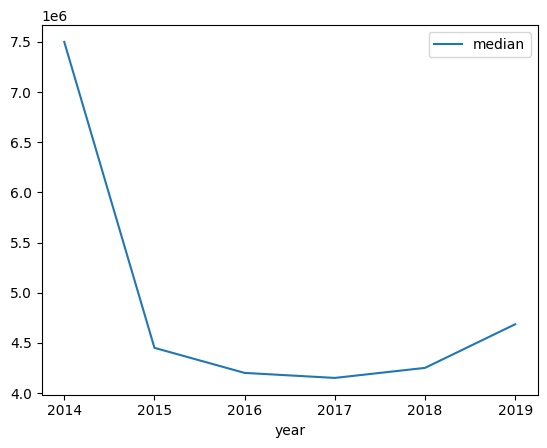

In [34]:
pivot_table_year = data.pivot_table(index = 'year', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_year.columns = ['mean', 'count', 'median']
pivot_table_year.plot(y = 'median')

pivot_table_year.sort_values('median', ascending = False)

Вывод: Из данных видно, что в период с 2014 по 2017 год цены на недвижимость снижались, но начиная с этого момента начали постепенно расти.

                 count          mean
locality_name                       
Санкт-Петербург  10794  5.612108e+06
               count          mean
locality_name                     
Выборг           199  2.959422e+06


<Axes: xlabel='locality_name'>

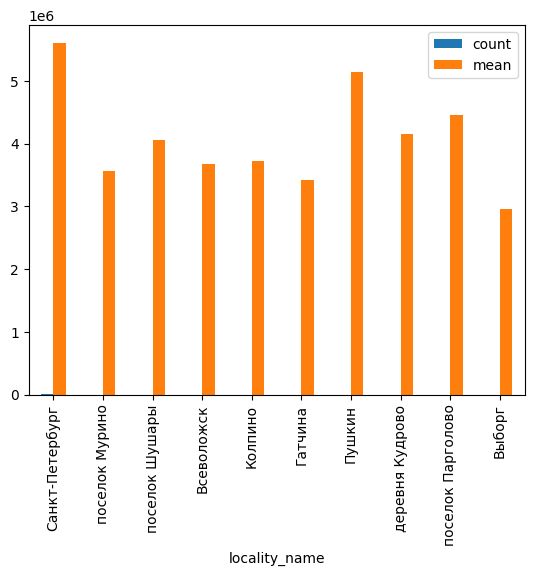

In [35]:
locality_pivot_table = data.pivot_table(index = 'locality_name', values = 'last_price', aggfunc=['count', 'mean'])
locality_pivot_table.columns = ['count', 'mean']
locality_pivot_table = locality_pivot_table.sort_values('count', ascending = False).head(10)
#самая высокая стоимость
print (locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].max()])
#самая низкая стоимость
print (locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].min()])
# столбчатая диаграмма стоимости квадратного метра по топ 10 населенным пунктам.
locality_pivot_table.plot(kind = 'bar')

Вывод: Из анализа 10 населённых пунктов с наибольшим количеством объявлений видно, что самая высокая стоимость жилья наблюдается в Санкт-Петербурге, в то время как наиболее низкая стоимость фиксируется в Выборге.

                          last_price
cityCenters_nearest_km              
0                       7.678917e+06
1                       9.024122e+06
2                       8.013456e+06
3                       7.920113e+06
4                       8.321021e+06
5                       8.101953e+06
6                       7.088272e+06
7                       7.534200e+06
8                       6.165904e+06
9                       5.327082e+06
10                      5.119111e+06
11                      5.267010e+06
12                      5.419518e+06
13                      5.426211e+06
14                      5.152231e+06
15                      5.070465e+06
16                      4.864706e+06
17                      4.580642e+06
18                      4.597908e+06
19                      4.547926e+06
20                      5.786016e+06
21                      4.867449e+06
22                      5.140077e+06
23                      4.181120e+06
24                      3.626429e+06
2

<Axes: xlabel='cityCenters_nearest_km'>

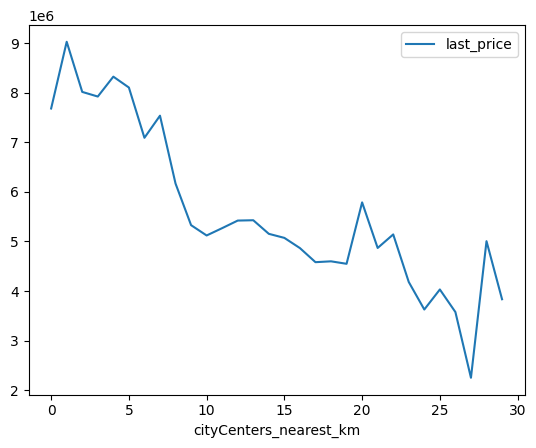

In [36]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].fillna('-')
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].astype('int')
pivot_table_km = data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km !="-"').pivot_table(index = 'cityCenters_nearest_km', values = 'last_price', aggfunc= 'mean')
print(pivot_table_km)
pivot_table_km.plot()

Вывод: Исходя из графика, видно, что чем ближе обьект к центру города, тем дороже обьект.

## Общий вывод

Была выполнена предобработка данных, где было удалено большое количество пропусков, дубликатов и изменнены типы данных. Далее был проведен анализ данных из которого мы выяснили, что основным критерием для определения стоимости жилья является цена за квадратный метр. Общая площадь, соотношение жилой и общей площади, а также отношение кухонной площади к общей могут помочь определить предпочтительные типы квартир. Анализ дат продаж позволяет определить оптимальный момент для запуска рекламной кампании и продажи недвижимости, учитывая сезонные и долгосрочные тенденции. Количество сделок по годам может быть связано с динамикой населения города.

Этаж, на котором находится квартира, также играет важную роль. Обычно первые этажи считаются менее привлекательными из-за безопасности, а последние этажи могут вызвать опасения из-за возможных проблем с крышей. Поэтому квартиры, расположенные между первым и последним этажами, считаются наиболее комфортными и, следовательно, имеют более высокую цену.

Пригородные районы Санкт-Петербурга обычно имеют более низкие цены на недвижимость из-за отсутствия престижа и удаленности от центра города. В то время как центр города обычно предлагает высококачественные квартиры с соответствующими планировками и, следовательно, имеет самые высокие цены на жилье в регионе.